In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

In [9]:
train_dir = 'data/cats_and_dogs/train'
test_dir = 'data/cats_and_dogs/val'

In [53]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])
transform

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [54]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

In [55]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Text(0.5, 1.0, 'Label: 1')

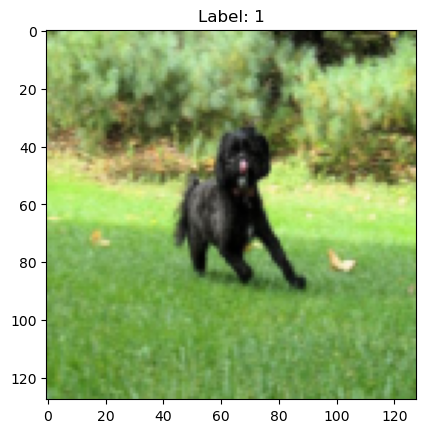

In [56]:
# Denormalize
def denormalize(img_tensor, mean, std):
    img = img_tensor.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

random_number = random.randint(0, len(train_dataset) - 1)
image, label = train_dataset[random_number]
image = denormalize(image, mean, std)
plt.imshow(image.permute(1, 2, 0).numpy()) # CHW to HWC
plt.title(f'Label: {label}')

In [71]:
class CatsDogs(nn.Module):
    def __init__(self):
        super(CatsDogs, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [72]:
model = CatsDogs()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [74]:
for epoch in range(20):
    for images, labels in train_loader:
        labels = labels.float().unsqueeze(1)
        outputs = model(images)
        loss = criterion(torch.sigmoid(outputs), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 42.1053
Epoch [2/100], Loss: 36.8421
Epoch [3/100], Loss: 36.8421
Epoch [4/100], Loss: 42.1053
Epoch [5/100], Loss: 26.3158
Epoch [6/100], Loss: 31.5789
Epoch [7/100], Loss: 57.8947
Epoch [8/100], Loss: 36.8421
Epoch [9/100], Loss: 10.5263
Epoch [10/100], Loss: 31.5789
Epoch [11/100], Loss: 26.3158
Epoch [12/100], Loss: 47.3684
Epoch [13/100], Loss: 42.1053
Epoch [14/100], Loss: 31.5789
Epoch [15/100], Loss: 36.8421
Epoch [16/100], Loss: 47.3684
Epoch [17/100], Loss: 21.0526
Epoch [18/100], Loss: 26.3158
Epoch [19/100], Loss: 21.0526
Epoch [20/100], Loss: 26.3158


In [79]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        labels = labels.float().unsqueeze(1)
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

Accuracy of the model on the test images: 65.71%
